In [3]:
import pandas as pd
import numpy as np
from plotnine import *
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [4]:
# Read in the data
cell = pd.read_csv("cell-count.csv")

# 1. Convert Cell Count to Relative Frequency

In [5]:
# Select Relevant Columns
cell_cols = ["b_cell", "cd8_t_cell", "cd4_t_cell", "nk_cell", "monocyte"]
dat = cell[cell_cols + ["sample"]].copy()

# Create a "total cell count" column
dat["total_count"] = dat[cell_cols].sum(axis=1)

# Convert from a wide to long format
dat = pd.melt(dat, id_vars = ["sample", "total_count"],
              var_name = "population",
              value_name = "count")

# Calculate Cell frequencies
dat = dat.assign(percentage = lambda x : 100 * x["count"] / x["total_count"])

# Write out the dataframe to a csv file
dat.to_csv("output_files/problem1.csv", index = False)

# 2. Responder/Non-Responder Statistics

## Part A: Boxplots

c:\Users\rileyw\anaconda3\envs\cyberwise\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\rileyw\anaconda3\envs\cyberwise\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: output_files/problem2A_plot.png


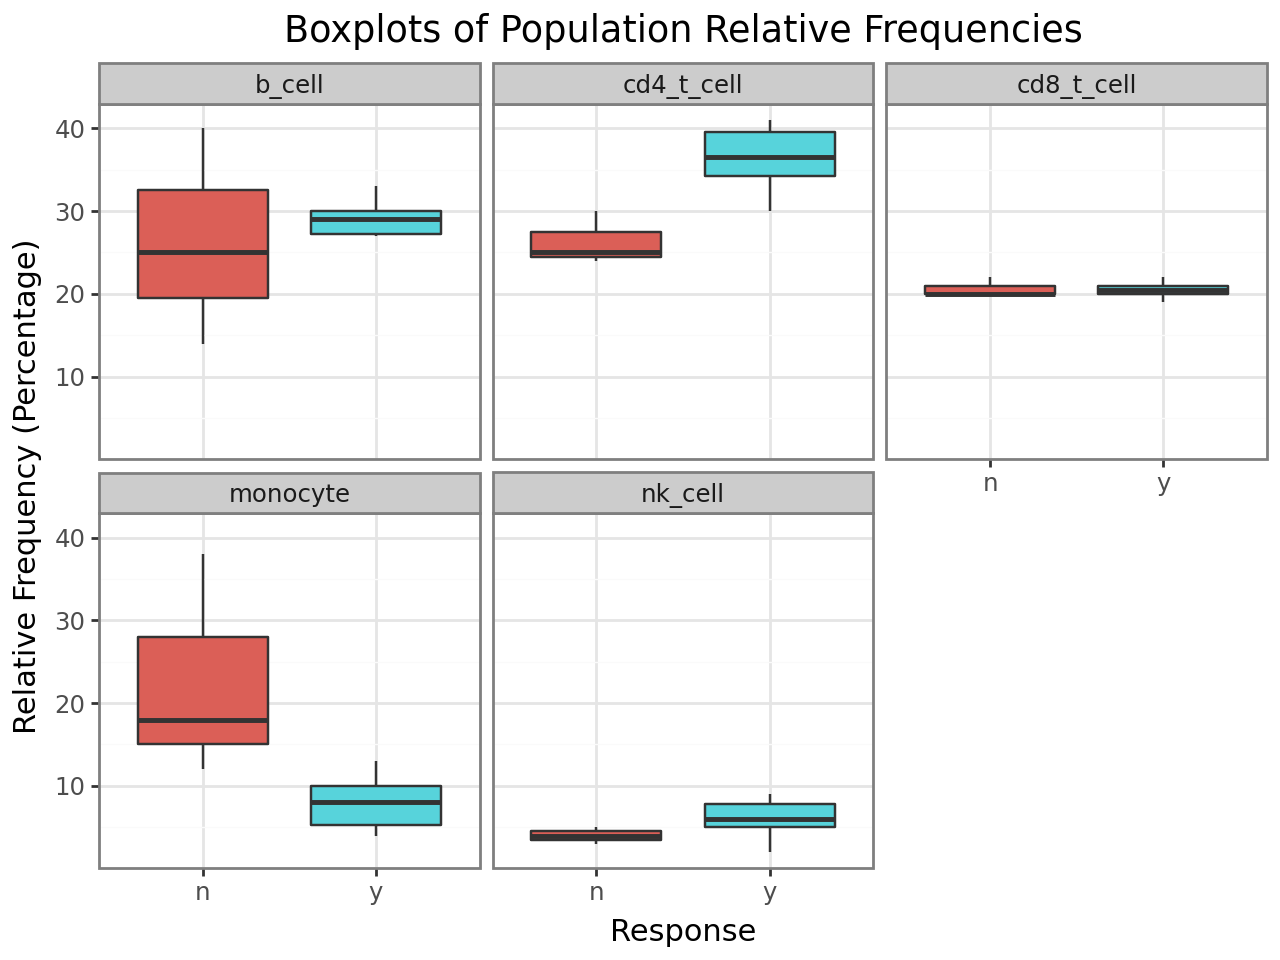

In [6]:
# Filter to the relevant data
dat2 = cell[(cell["treatment"] == "tr1") & (cell["condition"] == "melanoma")] \
    [["sample", "response"]] \
    .copy()

# Join Relative Frequency Data with reponses and treatments
dat2 = pd.merge(dat, dat2, how = "inner", on = "sample")

# Make boxplots
rel_frq_plot = ggplot(dat2, aes(x = "response", y = "percentage", fill = "response")) \
+ geom_boxplot() \
+ facet_wrap("~population") \
+ theme_bw() \
+ theme(legend_position = "none") \
+ labs(
    title = "Boxplots of Population Relative Frequencies",
    x = "Response",
    y = "Relative Frequency (Percentage)"
)

# Save the Plot to a file
rel_frq_plot.save("output_files/problem2A_plot.png", dpi=500)

# Show Boxplots Inline
rel_frq_plot

# Part B: Statistics

In [9]:
results = {"population" : [],
           "test" : [],
           "p-value" : []}

# Run through a loop of each cell population
for i in dat2["population"].unique():
    # Get data for each cell population
    tmp = dat2[dat2["population"] == i].copy()
    pop1 = tmp[tmp["response"] == "y"]["percentage"]
    pop2 = tmp[tmp["response"] == "n"]["percentage"]
    
    # Calculate Two Sample T-Test Statistic
    stat, t_p_value = ttest_ind(pop1, pop2)

    # Record Results
    results["population"].append(i)
    results["test"].append("t_test")
    results["p-value"].append(t_p_value)

    # Calculate Wilcoxon Rank-Sum Test (More Robust)
    stat, w_p_value = mannwhitneyu(pop1, pop2)

    # Record Results
    results["population"].append(i)
    results["test"].append("Wilcoxon")
    results["p-value"].append(w_p_value)

results_df = pd.DataFrame(results)

# Write out the results to a CSV file
results_df.to_csv("output_files/problem2B_results.csv", index = False)

# Display Relevant Results
results_df[results_df["p-value"] < 0.06]

,population,test,p-value
4,cd4_t_cell,t_test,0.008351
5,cd4_t_cell,Wilcoxon,0.038056
8,monocyte,t_test,0.033508
9,monocyte,Wilcoxon,0.051822


It looks like both the cd4 t-cell and the monocyte cells are likely to be significantly different between responders and non-responders as they both had low p-values for the two sample t-test and the wilcoxon rank sum test. The cd4 t-cells are significantly different as the p-value for the wilcoxon rank sum test (a robust version of the two sample t test when the data are non-normal) is less than the typical alpha value of 0.05